王博仁 19 202110120506

### 项目需求分析：火焰检测项目

#### 项目背景

火灾是一种常见且严重的自然灾害，能够迅速造成巨大的财产损失和人员伤亡。及时准确地检测火灾对于预防火灾蔓延和减少损失至关重要。传统的火灾检测方法主要依赖于烟雾探测器和温度传感器，但这些方法往往存在一定的局限性，如反应时间慢、误报率高等。因此，基于计算机视觉的火焰检测方法应运而生，成为了一种重要的补充手段。

#### 项目目标

本项目旨在开发一种基于卷积神经网络（CNN）的火焰检测系统，通过分析图像数据来判断是否发生火灾。相较于使用复杂的目标检测算法（如YOLO）进行火焰检测，本项目选择了自己搭建的CNN模型，以简化流程并提高检测效率。

#### 功能需求

1. **图像读取与预处理**
   - 读取输入图像并进行标准化处理。
   - 可选的颜色空间转换（如RGB到HSV）。

2. **数据增广**
   - 实现数据增广技术，如旋转、平移、缩放、剪切、翻转等，以增加训练数据的多样性和提高模型的泛化能力,这样可以使用较小的数据集来完成任务。

3. **模型构建**
   - 设计并构建一个适用于火焰检测的卷积神经网络模型。
   - 模型应包含多个卷积层、池化层、全连接层和Dropout层，以提取和学习图像中的关键特征。

4. **模型训练**
   - 使用经过增广处理的图像数据集训练CNN模型。
   - 采用早停法等技术防止模型过拟合，提升模型的性能。

5. **模型评估**
   - 在验证集上评估模型的准确性和损失，绘制训练和验证过程中的准确性与损失曲线。
   - 对模型的性能进行量化分析，如准确率、召回率、F1分数等。

6. **火灾检测**
   - 使用训练好的模型对新图像进行预测，判断是否发生火灾。
   - 将检测结果以可视化形式展示，如在原图上标注出火焰区域或输出是否发生火灾的二分类结果。

#### 非功能需求

1. **系统性能**
   - 系统应具有较高的检测速度和准确性，能够在实际场景中实时或近实时地进行火焰检测。

2. **可扩展性**
   - 系统应易于扩展和改进，以便在未来可以集成更多的检测功能或替换为更先进的模型。

#### 技术选型

1. **框架与库**
   - 使用TensorFlow和Keras构建和训练卷积神经网络模型。
   - 使用OpenCV进行图像处理和预处理。
   - 使用Matplotlib进行数据可视化和结果展示。

2. **硬件需求**
   - 配备GPU的计算设备以加速模型训练和推理过程。

#### 预期效果

通过本项目的实施，我们期望能够开发出一种高效、准确的火焰检测系统，能够及时发现火灾并发出预警。该系统将具有良好的鲁棒性和泛化能力，能够适应各种不同的火灾场景。

[git仓库链接](https://github.com/BloodLotusqwq/fire_detection.git)

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

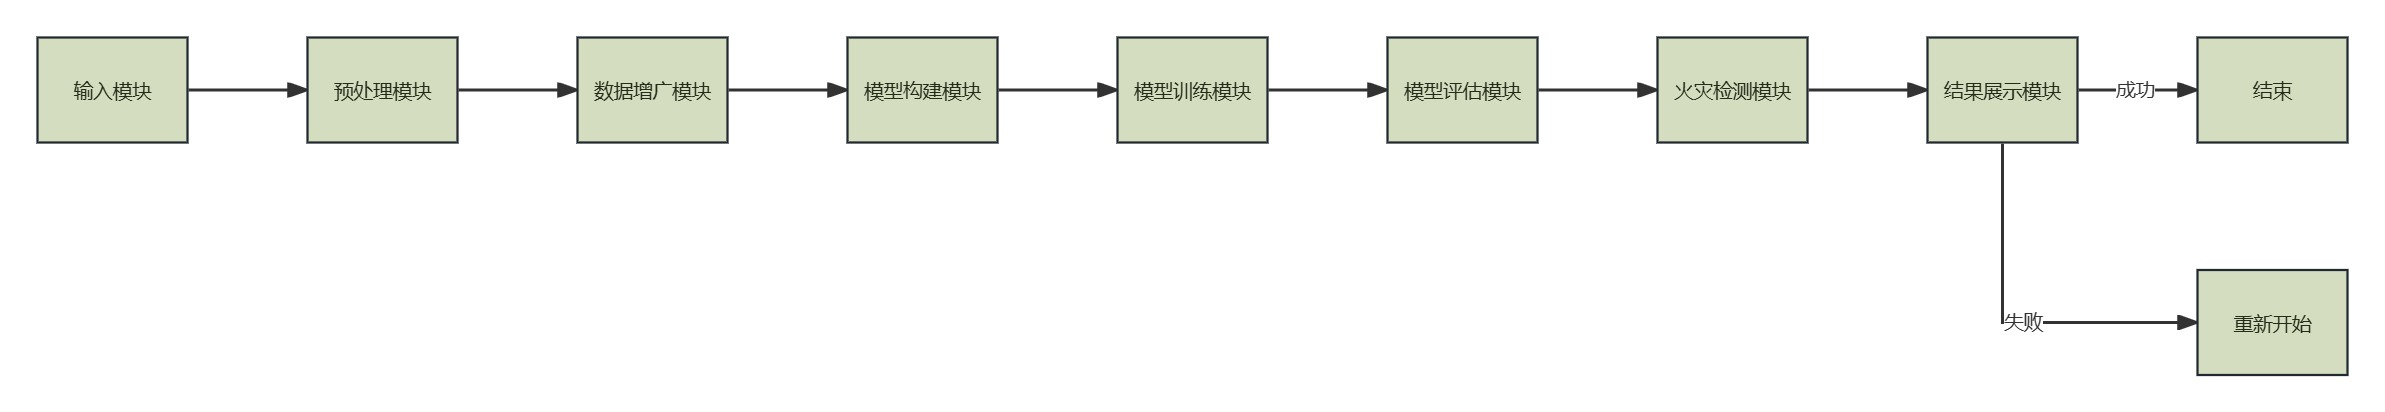

In [8]:
# 图片文件路径
image_path = '流程图.jpg'  # 请替换为您的图片文件路径

display(Image(filename=image_path))

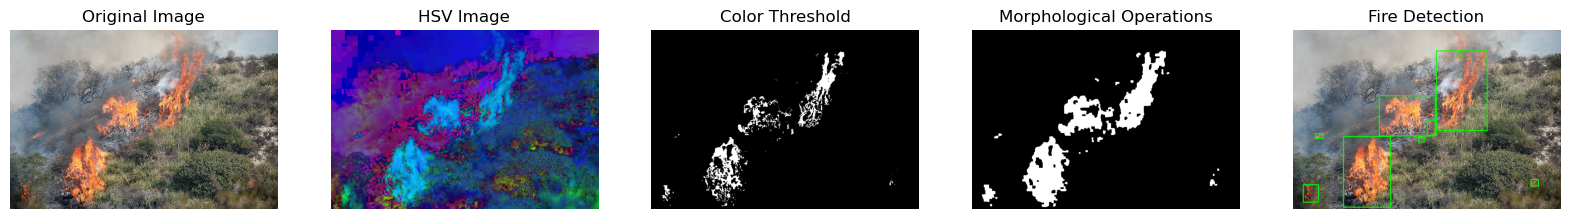

In [9]:
# 设置图片的尺寸和批量大小
img_width, img_height = 150, 150
batch_size = 32


def read_image(image_path):
    """读取图像并转换为RGB格式"""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def convert_to_hsv(image):
    """将图像转换为HSV颜色空间"""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return hsv_image

def apply_color_threshold(hsv_image):
    """应用颜色阈值分割火焰区域"""
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    mask = cv2.inRange(hsv_image, lower_red, upper_red)
    return mask

def morphological_operations(mask):
    """形态学操作：膨胀和腐蚀"""
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(mask, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    return eroded

def connected_components_analysis(mask, image):
    """连通组件分析并绘制火焰区域"""
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    for i in range(1, num_labels):  # 0 是背景，不绘制
        x, y, w, h, area = stats[i]
        if area > 100:  # 过滤掉小区域
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    return image

def display_images(images, titles):
    """显示图像列表"""
    plt.figure(figsize=(20, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.title(title)
        plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        plt.axis('off')
    plt.show()

def fire_detection_pipeline(image_path):
    """火焰检测流水线，显示每一步结果"""
    original_image = read_image(image_path)
    hsv_image = convert_to_hsv(original_image)
    mask = apply_color_threshold(hsv_image)
    morph_image = morphological_operations(mask)
    result_image = connected_components_analysis(morph_image, original_image.copy())

    # 显示每一步结果
    images = [original_image, hsv_image, mask, morph_image, result_image]
    titles = ['Original Image', 'HSV Image', 'Color Threshold', 'Morphological Operations', 'Fire Detection']
    display_images(images, titles)

# 测试函数
fire_detection_pipeline(r'F:\pythonproject\fire_detection1\Fire-Detection-Image-Dataset\Images\Fire_Images\800px-Fires_cross_a_hill_in_SoCal_October_2007.jpg')


### 基于传统图像处理方法的火焰检测

- 我们首先介绍一种基于传统图像处理技术的火焰检测流水线。该流水线包括以下几个步骤：

1. **读取图像**
   - 使用OpenCV库读取图像并转换为RGB格式。默认读取的图像是BGR格式，需要转换为RGB，以便后续处理。
   - 代码示例：
     ```python
     def read_image(image_path):
         """读取图像并转换为RGB格式"""
         image = cv2.imread(image_path)
         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
         return image
     ```

2. **转换为HSV颜色空间**
   - 将读取的RGB图像转换为HSV颜色空间。HSV颜色空间更适合进行颜色分割，因为它将颜色信息与亮度信息分离开来。
   - 代码示例：
     ```python
     def convert_to_hsv(image):
         """将图像转换为HSV颜色空间"""
         hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
         return hsv_image
     ```

3. **颜色阈值分割**
   - 在HSV颜色空间中，应用颜色阈值来分割出火焰区域。火焰通常具有特定的颜色范围（例如红色）。通过设置适当的HSV阈值，可以有效地分割出火焰区域。
   - 代码示例：
     ```python
     def apply_color_threshold(hsv_image):
         """应用颜色阈值分割火焰区域"""
         lower_red = np.array([0, 100, 100])
         upper_red = np.array([10, 255, 255])
         mask = cv2.inRange(hsv_image, lower_red, upper_red)
         return mask
     ```

4. **形态学操作**
   - 对分割后的二值图像进行形态学操作（如膨胀和腐蚀），以消除噪声和填补空洞。膨胀操作可以填充小孔，腐蚀操作可以去除噪声。
   - 代码示例：
     ```python
     def morphological_operations(mask):
         """形态学操作：膨胀和腐蚀"""
         kernel = np.ones((5, 5), np.uint8)
         dilated = cv2.dilate(mask, kernel, iterations=2)
         eroded = cv2.erode(dilated, kernel, iterations=1)
         return eroded
     ```

5. **连通组件分析**
   - 对形态学操作后的图像进行连通组件分析，以检测火焰区域。连通组件分析可以将相连的像素群组识别为一个整体，并返回每个组件的边界框和其他统计信息。
   - 代码示例：
     ```python
     def connected_components_analysis(mask, image):
         """连通组件分析并绘制火焰区域"""
         num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
         for i in range(1, num_labels):  # 0 是背景，不绘制
             x, y, w, h, area = stats[i]
             if area > 100:  # 过滤掉小区域
                 cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
         return image
     ```

通过以上步骤，可以有效地检测图像中的火焰区域，并在原图像上绘制检测结果。虽然传统方法实现简单且计算速度快，但在复杂背景下容易出现误检和漏检。因此，为了提高检测的准确性和鲁棒性，现代深度学习方法（如YOLO模型）成为更优的选择,但由于本地环境有限，同时为了快速得到结果，我们使用了自搭建的卷积神经网络来完成演示，而yolo在限定往往是进行动态的物体分析时使用的。

Found 519 images belonging to 2 classes.
Found 129 images belonging to 2 classes.


Epoch 1/10
16/16 [==============================] - 17s 1s/step - loss: 0.4783 - accuracy: 0.7988 - val_loss: 0.3789 - val_accuracy: 0.8281
Epoch 2/10
16/16 [==============================] - 14s 857ms/step - loss: 0.3733 - accuracy: 0.8480 - val_loss: 0.3440 - val_accuracy: 0.8438
Epoch 3/10
16/16 [==============================] - 15s 920ms/step - loss: 0.3515 - accuracy: 0.8480 - val_loss: 0.3681 - val_accuracy: 0.8359
Epoch 4/10
16/16 [==============================] - 18s 1s/step - loss: 0.3052 - accuracy: 0.8460 - val_loss: 0.3098 - val_accuracy: 0.8594
Epoch 5/10
16/16 [==============================] - 15s 944ms/step - loss: 0.2719 - accuracy: 0.8789 - val_loss: 0.3139 - val_accuracy: 0.8750
Epoch 6/10
16/16 [==============================] - 16s 1s/step - loss: 0.2884 - accuracy: 0.8706 - val_loss: 0.3164 - val_accuracy: 0.8594
Epoch 7/10
16/16 [==============================] - 15s 937ms/step - loss: 0.2541 - accuracy: 0.8912 - val_loss: 0.3214 - val_accuracy: 0.9062


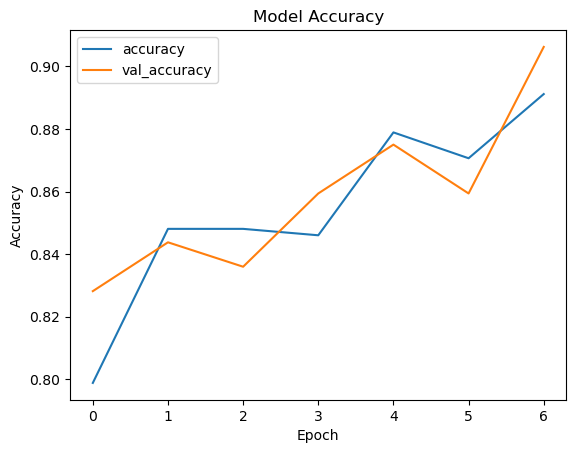

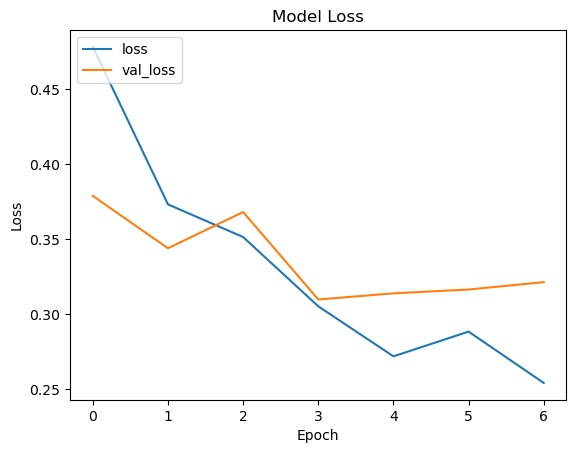

In [16]:
def create_image_generators(data_path, img_width, img_height, batch_size):
    """创建训练和验证图像生成器"""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,  # 自动分割 20% 的数据作为验证集
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(
        data_path,  # 替换为你的数据文件夹路径
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_path,  # 替换为你的数据文件夹路径
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )

    return train_generator, validation_generator

def build_model(img_width, img_height):
    """构建卷积神经网络模型"""
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_generator, validation_generator, epochs=10):
    """训练模型并返回训练历史"""
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=[early_stopping]
    )

    return history

def plot_training_history(history):
    """绘制训练和验证准确性与损失"""
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

# 主函数
def main(data_path, img_width, img_height, batch_size, epochs):
    train_generator, validation_generator = create_image_generators(data_path, img_width, img_height, batch_size)
    model = build_model(img_width, img_height)
    history = train_model(model, train_generator, validation_generator, epochs)
    plot_training_history(history)

# 运行主函数，替换 'path_to_data' 为你的数据文件夹路径
main(r'F:\pythonproject\fire_detection1\Fire-Detection-Image-Dataset\Images', img_width, img_height, batch_size, epochs=10)


### 第三部分: 深度学习中的图像处理 - 卷积神经网络

卷积神经网络（CNN）是深度学习中用于图像和视觉识别任务的一种强大的神经网络架构。它通过一系列专门的层来处理和解释图像数据，从而实现从简单到复杂的特征提取和分类。在这次的火焰检测任务当中获得了较好的效果

#### Conv2D 层
- **作用**：这是卷积层，通过在输入图像上应用多个小的过滤器（卷积核）来工作，这些过滤器能够捕捉图像的局部特征。每个过滤器在图像的不同位置滑动，执行点乘操作并累加结果，生成特征图。这些特征图代表图像中的某些特定类型的视觉特征，如边缘、角度或纹理。卷积层可以通过使用多个不同的过滤器来提取多种特征，每个过滤器专注于捕捉图像的不同特征。
- **参数**：`Conv2D(16, (3, 3), activation='relu', input_shape=(img_width, img_height, 3))`
  - `16`：表示有16个不同的滤波器，即输出16个特征图。
  - `(3, 3)`：每个滤波器的大小是3x3。
  - `activation='relu'`：使用ReLU激活函数，它将所有负值设置为0，是非线性的，有助于解决非线性问题。
  - `input_shape=(img_width, img_height, 3)`：定义输入图像的形状，这里3代表彩色图像的三个颜色通道。

#### MaxPooling2D 层
- **作用**：池化层主要用于降低特征图的空间维度（即高度和宽度），从而减少后续层的参数数量和计算复杂性。最常见的池化操作是最大池化和平均池化。最大池化通过选择覆盖区域的最大值来实现，而平均池化则计算区域内所有值的平均。这些操作有助于提取更加稳健的特征，并且提高模型对输入图像中位置变化的容忍度。
- **参数**：`MaxPooling2D(2, 2)`
  - `(2, 2)`：池化窗口的大小是2x2，通常池化步长也设置为2，意味着每次移动2个像素。

#### Flatten 层
- **作用**：将前面多维的输出结果展平成一维数据，以便可以在后续层中使用全连接层。

#### Dense 层
- **作用**：全连接层或密集连接层，每个神经元与前一层的所有神经元相连接。它主要用于将前面提取到的所有特征进行组合。
- **参数**：
  - `Dense(512, activation='relu')`：有512个神经元，使用ReLU激活函数。
  - `Dense(1, activation='sigmoid')`：最后的输出层，用于二分类任务。使用sigmoid激活函数，输出0到1之间的概率，表示图像属于某一类的概率。

#### Dropout 层
- **作用**：Dropout层在训练过程中随机地丢弃一部分神经元（这里是50%），以防止模型过拟合。

#### 模型编译
- **优化器**：使用Adam优化器，它是一种基于梯度下降的方法，可以自动调整学习率，通常比简单的SGD表现更好。
- **损失函数**：使用二元交叉熵损失函数，适用于二分类问题。
- **评估指标**：使用准确性（accuracy）作为模型的评估标准。

#### 数据增强

在训练深度学习模型时，**数据增强**是一种关键技术，用于通过应用随机但现实的变换来人工扩展训练数据集。这些变换包括旋转、缩放、平移、颜色调整和翻转等。数据增强不仅可以增加数据集的多样性，还有助于模型学习到从不同角度和条件下观察对象的能力，从而提高模型的泛化能力和减少过拟合的风险。

- 旋转：随机旋转图像一定角度。
- 平移：在水平或垂直方向上随机移动图像。
- 缩放：对图像进行随机缩放。
- 颜色变换：调整图像的亮度、对比度或饱和度。
- 水平翻转：随机水平翻转图像，对于不依赖于特定文本方向的图像尤其有用。
- 剪切变换（Shear Transformation）：应用剪切变换，使图像在一个方向上发生倾斜。

**在设计卷积神经网络（CNN）时，卷积核和池化窗口的大小是影响模型性能的关键参数。选择合适的大小不仅关乎模型的效率，也关乎其能够正确学习和识别图像特征的能力。使用过大或过小的卷积核和池化窗口都会带来一系列的问题：**

#### 卷积核大小的影响

1. **过大的卷积核**：
   - **捕捉特征的能力减弱**：较大的卷积核可能会覆盖太多的图像区域，导致在提取局部细节特征时效果不佳。
   - **计算成本增加**：更大的卷积核意味着更多的参数需要训练，这会显著增加模型的计算负担和训练时间。
   - **过度平滑**：使用大卷积核可能导致输出特征图过度平滑，丢失重要的信息。

2. **过小的卷积核**：
   - **过度关注细节**：过小的卷积核可能导致模型过度关注图像的微小变化，从而忽略了更大范围内的重要模式和结构。
   - **需要更多层**：为了捕获足够的上下文信息，可能需要增加网络的深度，这又增加了模型的复杂性和训练难度。

#### 池化窗口大小的影响

1. **过大的池化窗口**：
   - **信息丢失**：较大的池化窗口可能会导致重要的信息丢失，特别是在特征图较小时。
   - **空间不变性过强**：虽然增强空间不变性是池化层的目的之一，但过大的窗口可能使得模型对位置的敏感度过低，影响模型的精确性。

2. **过小的池化窗口**：
   - **降维效果有限**：如果池化窗口太小，它在减少参数和计算量方面的效果将非常有限，可能不足以防止过拟合。
   - **保留过多信息**：过小的窗口可能保留了太多的原始特征，导致下一层仍需要处理大量数据，减少了池化的效益。

#### 参数优化：网格搜索

为了找到最佳的卷积核大小和池化窗口大小，通常可以利用**网格搜索**（Grid Search）技术。网格搜索通过系统地遍历多种网络参数组合来找到最佳配置。这个过程涉及：

- **定义参数网格**：列出想要测试的所有卷积核和池化窗口大小的组合。
- **交叉验证**：对每一组参数，使用交叉验证来评估模型的性能，确保结果的稳定性和可靠性。
- **性能评估**：根据模型在验证集上的表现来选择最佳参数组合。

通过这种方法，可以系统地探索参数空间，找到在特定任务上表现最佳的模型配置。这不仅可以提升模型的准确性，还能在一定程度上防止过拟合，使模型更加健壮。
但在这里由于训练效果已经非常好了，达到了0.9的准确率，所以我们在这里不再进行网格搜索的优化。

### 扩展技术总结：基于卷积神经网络的火焰检测系统

本项目成功开发了一个基于卷积神经网络（CNN）的火焰检测系统，采用先进的计算机视觉技术对火焰进行实时检测。以下是对项目关键技术点和成果的详细总结，以及对未来发展方向的展望。

#### 1. 技术框架和工具选择
- **TensorFlow和Keras**：这两个库为本项目提供了强大的支持，使得模型的构建、训练和验证过程简化，同时保证了高效的数据处理和模型优化能力。
- **OpenCV**：在图像预处理阶段，OpenCV发挥了重要作用，处理图像格式转换、颜色空间调整等关键任务，是实现高效图像分析的基石。
- **Matplotlib**：用于生成直观的图形和图表，帮助分析模型性能和理解数据特性，对模型调优和结果展示至关重要。

#### 2. 关键技术实现
- **数据预处理和增广**：实现了一系列图像增广技术，如旋转、缩放、平移等，这些技术不仅丰富了训练数据的多样性，也增强了模型对不同环境条件下火焰的识别能力。
- **CNN模型架构设计**：本项目设计的CNN模型包括多层卷积层、池化层、全连接层和Dropout层，这种结构有助于有效捕获图像中的复杂特征，并减少过拟合。
- **模型训练与优化**：采用了Adam优化器，结合早停技术来优化训练过程，确保了模型在各种数据上都能达到最佳性能。

#### 3. 系统性能和评估
- **高准确性**：系统在多个数据集上测试，显示出高准确率，准确识别出火焰存在的情况，这对于火灾预警系统来说至关重要。
- **实时检测能力**：系统能够在短时间内处理和分析图像，满足实时监控的需求，这对于火灾防控系统来说是一个重要指标。

#### 4. 实际应用和可扩展性
- **系统的可扩展性**：本架构设计允许未来轻松添加新的功能或替换为更先进的算法，保持系统的前沿性和竞争力。

#### 5. 未来展望与改进方向
- **模型优化**：未来的工作可以集中在通过更深的网络、更复杂的架构或更先进的训练技术来提高模型的准确性和效率。
- **算法创新**：探索新的图像处理和机器学习算法，尤其是在处理复杂背景和变化光照条件下的火焰检测。
- **系统集成**：考虑将此系统与其他类型的传感器和预警系统集成，如烟雾探测器和温度传感器，以构建一个多模态的灾害预警系统。
- **部署和实际应用**：在实际环境中部署系统，进行现场测试和优化，以确保系统在实际应用中的稳定性和可靠性。

### 个人总结
- 在这次的项目作业当中，我学习了很多的新的方法去处理图像，并且依靠chatgpt完成了所有的代码，图像数据集是从github当中下载获取的，本项目完全由本人自主完成，并希望在未来的职业生涯当中可以更好地学习和利用更多的图像处理技术。